In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import mutual_info_classif as MIC

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# prepare colors for plot
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec_m = sns.color_palette("dana", n_colors=27)


from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

# prepare colors for plot
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana_f", cmap)
phasec_f = sns.color_palette("dana_f", n_colors=27)

/tmp/ipykernel_10295/1056814220.py:11: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)
/tmp/ipykernel_10295/1056814220.py:25: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana_f", cmap)


## data female

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

# take only first sample from each week
ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks

sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_female = pd.concat([sample,sample2])
df_female = sample.copy()
df_female.rename(columns={'binned_age': 'age'}, inplace=True)
df_female.set_index(['age', 'mouse'], inplace=True)

## data males

In [6]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male = sample.copy()
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

## normalized

In [7]:
# avarage per age or session
f_df= df_female.groupby(['age','mouse']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [8]:
## joint data
m_data=m_df.copy()
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data=f_df.copy()
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])

In [9]:
long_data = data.copy()
X = long_data.to_numpy()
y = list(long_data.index.get_level_values('mouse'))
mi_score_id = MIC(X,y)

In [10]:
n=10
id_indx = np.argsort(mi_score_id)[::-1][0:n] # syllble index
impsyl_id= list(long_data.columns[id_indx]) #syllable id
top_mi_score_id = mi_score_id[id_indx]
imp_id = np.array(['n']*len(mi_score_id))
imp_id[np.array(id_indx)]='y'

In [11]:
print('10 most informative syllables for identity: ',impsyl_id)

10 most informative syllables for identity:  [84, 97, 79, 83, 24, 76, 41, 60, 39, 23]


In [12]:
data=long_data[impsyl_id]

In [13]:
data

syllables             84        97        79        83        24        76  \
age  mouse sex                                                               
3.0  M1_01 m    0.000503  0.000503  0.000000  0.004527  0.018109  0.010563   
     M1_02 m    0.002198  0.000549  0.000000  0.003297  0.013187  0.001648   
     M1_03 m    0.000598  0.000000  0.000000  0.003586  0.011955  0.002391   
     M1_04 m    0.001698  0.000000  0.000000  0.004527  0.004527  0.005093   
     M2_01 m    0.001503  0.000000  0.000000  0.004509  0.012024  0.000501   
...                  ...       ...       ...       ...       ...       ...   
50.0 F4_04 f    0.014946  0.001401  0.014946  0.001868  0.017282  0.000934   
     F5_01 f    0.019501  0.012245  0.024943  0.003628  0.004989  0.003175   
     F5_02 f    0.005904  0.007266  0.027702  0.014986  0.005450  0.004995   
     F5_03 f    0.013679  0.000472  0.002830  0.004245  0.023585  0.006604   
     F5_04 f    0.008441  0.004965  0.024330  0.003972  0.006455  0.001490   

syllables             41        60        39        23  
age  mouse sex                                          
3.0  M1_01 m    0.008551  0.003521  0.009054  0.022636  
     M1_02 m    0.003846  0.001099  0.003297  0.026923  
     M1_03 m    0.014345  0.007770  0.006575  0.015541  
     M1_04 m    0.017544  0.006225  0.002264  0.016412  
     M2_01 m    0.025050  0.012525  0.005010  0.017535  
...                  ...       ...       ...       ...  
50.0 F4_04 f    0.003737  0.006539  0.001401  0.044372  
     F5_01 f    0.004989  0.009977  0.000454  0.027664  
     F5_02 f    0.001362  0.004087  0.002271  0.031789  
     F5_03 f    0.014151  0.003302  0.000943  0.063679  
     F5_04 f    0.000993  0.002483  0.000497  0.064052  

[1815 rows x 10 columns]

In [14]:
f_data=data.query('sex=="f"')
m_data=data.query('sex=="m"')

In [15]:
format_plots()

In [16]:
#met = 'jensenshannon'
met= 'cosine'

In [17]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in f_data.groupby('age'):
    inter_ind_dists = pdist(_df, metric=met)
    iid[age] = inter_ind_dists
    #iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age, mouse=_df.index.get_level_values('mouse'))))
iid_df = pd.concat(iid_df)
iid_avg_df_f = pd.concat(iid_avg_df)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


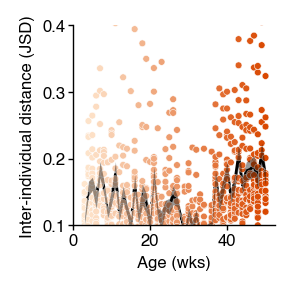

In [18]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
a = sns.scatterplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    palette=cmf,
    hue="age",
    legend=False,
    s=6,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a = sns.lineplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    zorder=-1,
    color='black',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    ylim=(0.1, 0.4),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    #xticks=[0,10,20,30,40,50],
)
sns.despine()

In [19]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_female_JSD.pdf')

In [20]:
iid = dict()
iid_df = []
iid_avg_df = []
for age, _df in m_data.groupby('age'):
    inter_ind_dists = pdist(_df, metric=met)
    iid[age] = inter_ind_dists
    iid_df.append(pd.DataFrame(dict(iid=inter_ind_dists, age=age)))
    d = squareform(inter_ind_dists)
    d[np.diag_indices_from(d)] = np.nan
    d = np.nanmean(d, axis=1)
    iid_avg_df.append(pd.DataFrame(dict(iid=d, age=age, mouse=_df.index.get_level_values('mouse'))))
iid_df = pd.concat(iid_df)
iid_avg_df_m = pd.concat(iid_avg_df)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


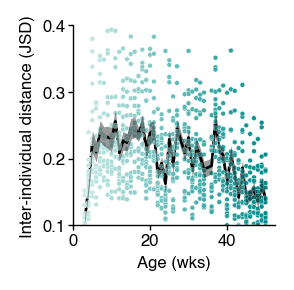

In [21]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))

a = sns.scatterplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    palette=cmm,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a = sns.lineplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    zorder=-1,
    color='black',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    ylim=(0.1, 0.4),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    #xticks=[0,10,20,30,40,50],
)
sns.despine()

In [22]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_male_JSD.pdf')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

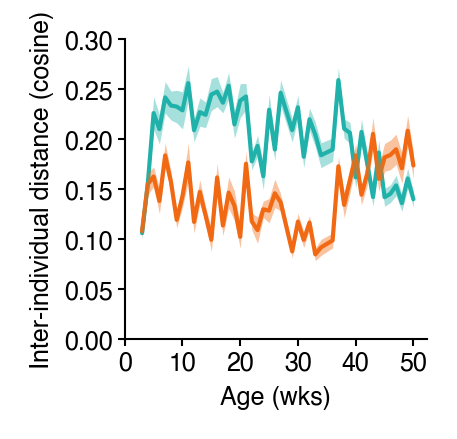

In [23]:
fig = figure(1.3, 1.3)
ax = fig.gca()
'''
a = sns.scatterplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    palette=cmm,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=1,
    zorder=1,
)
a = sns.scatterplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    palette=cmf,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=1,
    zorder=1,
)
'''
a = sns.lineplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    zorder=-1,
    color='#20B2AA',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)


a = sns.lineplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    zorder=-1,
    color='#f16913',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    ylim=(0, 0.3),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (cosine)",
    xticks=[0,10,20,30,40,50],
)

sns.despine()

In [24]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_fvm_MI_cosine.pdf')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

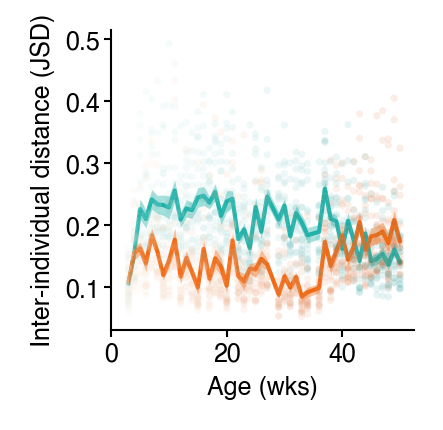

In [25]:
fig = figure(1.3, 1.3)
ax = fig.gca()

a = sns.scatterplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    palette=cmm,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=0.1,
    zorder=1,
)
a = sns.scatterplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    palette=cmf,
    hue="age",
    legend=False,
    s=3,
    linewidths=0,
    alpha=0.1,
    zorder=1,
)

a = sns.lineplot(
    data=iid_avg_df_m,
    x="age",
    y="iid",
    zorder=-1,
    color='#20B2AA',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)


a = sns.lineplot(
    data=iid_avg_df_f,
    x="age",
    y="iid",
    zorder=-1,
    color='#f16913',
    err_kws={"lw": 0, "alpha": 0.4},
    errorbar=("se"),
)
a.set(
    #ylim=(0.2, 0.3),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    #xticks=[0,10,20,30,40,50],
)

sns.despine()

In [26]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'inter_indv_distance_longv2_fvm_JSD_ylim.pdf')

In [27]:
def fit_2mixed_linear_models(data, dependent_var, factor1,factor2, group):
    
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]

    #formula = f'ranked_response ~ {factor1}*{group}'
    formula = f'ranked_response ~ {factor1}*C({factor2})'
        
    # Fit the mixed linear model
    model = smf.mixedlm(formula, align_data, groups=f'{group}')
    result = model.fit()
    return result

def extract_summary_to_dataframe(results, num_tests):
    summary_data = []

    for var, result in results.items():
        summary = result.summary()
        coefs = result.params
        pvalues = result.pvalues
        conf_int = result.conf_int()
        
        for param in coefs.index:
            pvalue_corrected = min(pvalues[param] * num_tests, 1.0)  # Apply Bonferroni correction
            
            summary_data.append({
                'Dependent Variable': var,
                'Parameter': param,
                'Coefficient': coefs[param],
                'P-value': pvalues[param],
                'Corrected P-value': pvalue_corrected,
                'CI Lower': conf_int[0][param],
                'CI Upper': conf_int[1][param]
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [28]:
iid_avg_df_m['sex']='m'
iid_avg_df_f['sex']='f'
temp=pd.concat([iid_avg_df_m,iid_avg_df_f])

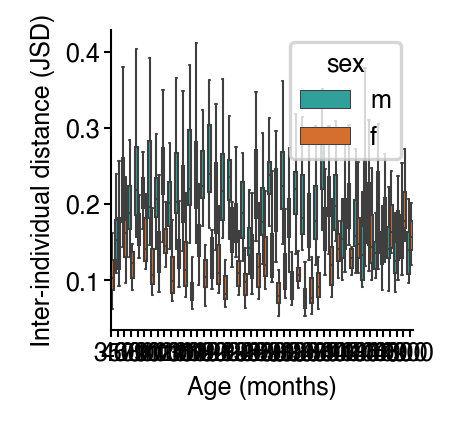

In [29]:
fig = figure(1.3, 1.3)
ax = fig.gca()

a = sns.boxplot(
    data=temp,
    x="age",
    y="iid",
    hue = 'sex',
    #zorder=-1,
    palette=['#20B2AA','#f16913'],
    #legend=False,
    showfliers=False,
    linewidth=0.5,
    #err_kws={"lw": 0, "alpha": 0.4},
    #errorbar=("se"),
)

a.set(
    #ylim=(0.15, 0.3),
    xlim=(0, None),
    xlabel="Age (months)",
    ylabel="Inter-individual distance (JSD)",
    #xticks=[0,10,20,30,40,50],
)

sns.despine()

In [30]:
# sm0oth version

/tmp/ipykernel_10295/1391820678.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  a = sns.lineplot(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


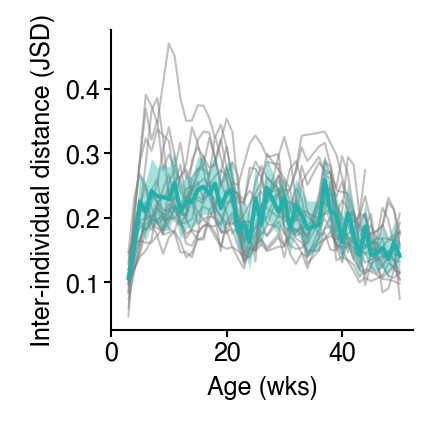

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
fig = figure(1.3, 1.3)
ax = fig.gca()

# Sample data preparation
# Assuming 'iid_avg_df_m' and 'iid_avg_df_f' are your DataFrames for male and female mice
# Each DataFrame has columns: 'age', 'iid', 'mouse'

# Define a function to smooth the data
def smooth_data(y, window_size=5, poly_order=2):
    return savgol_filter(y, window_size, poly_order)

# Plot individual lines for male mice
for mouse in iid_avg_df_m['mouse'].unique():
    mouse_data = iid_avg_df_m[iid_avg_df_m['mouse'] == mouse]
    smooth_iid = smooth_data(mouse_data['iid'])
    plt.plot(mouse_data['age'], smooth_iid, color='grey', lw=0.5, alpha=0.5, zorder=-2)

# Plot mean line for male mice with error bars
iid_avg_df_m['smoothed_iid'] = iid_avg_df_m.groupby('age')['iid'].transform(smooth_data)
a = sns.lineplot(
    data=iid_avg_df_m,
    x="age",
    y="smoothed_iid",
    color='#20B2AA',
    ci='sd',
    err_kws={"lw": 0, "alpha": 0.4},
)

# Set plot parameters
a.set(
    #ylim=(0.15, 0.5),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    #xticks=[0, 10, 20, 30, 40, 50],
)

sns.despine()
plt.show()

/tmp/ipykernel_10295/4039589844.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  a = sns.lineplot(
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


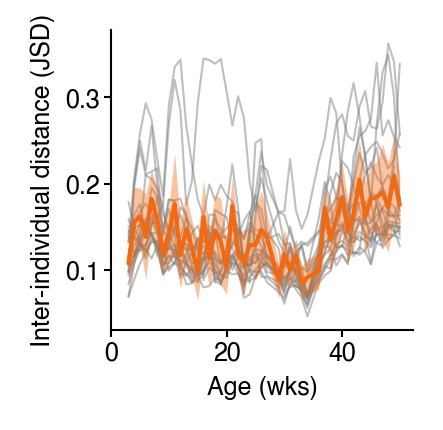

In [32]:
fig = figure(1.3, 1.3)
ax = fig.gca()

# Plot individual lines for female mice
for mouse in iid_avg_df_f['mouse'].unique():
    mouse_data = iid_avg_df_f[iid_avg_df_f['mouse'] == mouse]
    smooth_iid = smooth_data(mouse_data['iid'])
    plt.plot(mouse_data['age'], smooth_iid, color='grey', lw=0.5, alpha=0.5, zorder=-2)

# Plot mean line for female mice with error bars
iid_avg_df_f['smoothed_iid'] = iid_avg_df_f.groupby('age')['iid'].transform(smooth_data)
a = sns.lineplot(
    data=iid_avg_df_f,
    x="age",
    y="smoothed_iid",
    color='#f16913',
    ci='sd',
    err_kws={"lw": 0, "alpha": 0.4},
)

# Set plot parameters
a.set(
    #ylim=(0.15, 0.5),
    xlim=(0, None),
    xlabel="Age (wks)",
    ylabel="Inter-individual distance (JSD)",
    #xticks=[0, 10, 20, 30, 40, 50],
)
sns.despine()
plt.show()